# Sentence grammar acceptability (Español)

In [1]:
import torch
import transformers
import pandas as pd
import random
import numpy as np
import sklearn

In [2]:
from torch import nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
# import BERT modules
from transformers import BertTokenizer, BertConfig, BertModel, AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup

In [4]:
# progress bar for training
from tqdm import tqdm, trange

# utils
from sklearn.model_selection import train_test_split

## Importing [Spanish Corpus of Linguistic Acceptability](https://dataverse.csuc.cat/dataset.xhtml?persistentId=doi:10.34810/data1138) (EsCoLA) Dataset

In [5]:
df = pd.read_excel("EsCoLA_InDomainTrainDev.xlsx")

## Some Data exploration

In [6]:
df.head()

,ID,Source,Label,Source_annotation,Annotator_1,Annotator_2,Annotator_3,Human_annotation_median,Sentence,Category,Split
0,EsCoLA_5681,GDE35,1,NaN,1,0,1,1,¿Opinaron si debían hacerlo?,7,train
1,EsCoLA_8872,GDE51,1,NaN,1,1,1,1,¿Quién ha llamado?,7,train
2,EsCoLA_5661,GDE35,1,NaN,1,0,0,0,No se sabe donde ir.,7,train
3,EsCoLA_7328,GDE42,0,*,0,1,1,1,"Sólo tenía una peseta, y aquel tipo me pedía d...",14,train
4,EsCoLA_6179,GDE36,1,NaN,1,1,1,1,No sabe qué creer.,10,train


In [7]:
df.sample(5)

,ID,Source,Label,Source_annotation,Annotator_1,Annotator_2,Annotator_3,Human_annotation_median,Sentence,Category,Split
7270,EsCoLA_2045,GDE16,0,*,0,0,0,0,Escribió una cierta novela de misterio.,13,train
2967,EsCoLA_9285,GDE53,1,NaN,1,0,1,1,Empezando a llover salíamos de casa.,3,train
424,EsCoLA_6579,GDE38,1,NaN,1,1,1,1,Caminó tres kilómetros bien caminados.,3,train
1570,EsCoLA_10296,GDE65,1,NaN,1,1,1,1,Juan empezará a salir cuando terminen los exám...,9,train
7947,EsCoLA_75,GDE01,1,NaN,1,0,1,1,Lo encontré entre el barro.,11,train


- ID: Unique identifier for each sentence.
- Source: Reference source of the sentence.
- Label: Binary acceptability (1=Acceptable, 0=Unacceptable).
- Source_annotation: Acceptability from the original source (1=Acceptable, *=Unacceptable).
- Annotator_1, Annotator_2, Annotator_3: Human acceptability judgments (1 or 0).
- Human_annotation_median: Median of annotators’ judgments.
- Sentence: Sentence under evaluation.
- Category: Linguistic phenomenon (e.g., 7=Wh-phenomena).
- Split: Dataset split (train, dev, test).


We will keep only the important features: **Sentence, Label, Split**

In [8]:
df = df[['Sentence', 'Label', 'Split']]
df.sample(10)

,Sentence,Label,Split
366,No sé lo que hace Pedro.,1,train
6867,"A mi prima, parece que la van a contratar.",1,train
7348,"Ese nombre, ¿cómo se escribe?",1,train
1123,Oigo cantar una canción.,1,train
1809,¿Y qué quieres tú? ¿Que digan todo?,1,train
8298,Conocí a Juan mientras era de Cáceres.,0,train
2613,El libro el que compramos ayer era de física.,0,train
8185,Amo al chico que su padre es médico.,1,train
8809,"En términos más concretos, se puede afirmar qu...",1,dev
3951,Los misioneros que han sido cruelmente persegu...,1,train


Check size, NaN values, split sizes

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9507 entries, 0 to 9506
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  9507 non-null   object
 1   Label     9507 non-null   int64 
 2   Split     9507 non-null   object
dtypes: int64(1), object(2)
memory usage: 222.9+ KB


Check data balance:

In [10]:
print(f'Correct sentences: {df[df['Label'] == 1].shape[0]}')
print(f'Wrong sentences:   {df[df['Label'] == 0].shape[0]}')

Correct sentences: 6600
Wrong sentences:   2907


## Data preprocessing for BERT model

The pre-trained model used is a [base BERT for Spanish cased text](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)

### Adding BERT tokens

In [11]:
sentences = ["[CLS] "+sentence+" [SEP]" for sentence in df['Sentence'].values]
labels = df['Label'].values

### BERT tokenizer

In [12]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

In [13]:
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

In [14]:
sent_i = random.randint(0, len(sentences)-1)
print(f'Sentence: {sentences[sent_i]}')
print(f'Label: {labels[sent_i]}')
print(f'Tokenized sentence: {tokenized_sentences[sent_i]}')

Sentence: [CLS] Multitud de papeles rodaban por los suelos. [SEP]
Label: 1
Tokenized sentence: ['[CLS]', 'Multi', '##tud', 'de', 'papeles', 'ro', '##daba', '##n', 'por', 'los', 'suelos', '.', '[SEP]']


### Text preprocessing

In [15]:
print(f'Max tokenized sentence length: {max([len(tokenized) for tokenized in tokenized_sentences])}')

Max tokenized sentence length: 60


We choose a max fixed length of 128

In [16]:
# convert tokens to index number of its vocabulary
token_ids_sentences = [tokenizer.convert_tokens_to_ids(sentence) for sentence in tokenized_sentences]

def pad_sequences(sequences, max_len, padding_value=0):
    padded_sequences = []
    for seq in sequences:
        # if shorter, pad it
        if len(seq) < max_len:
            padding_to_add = [padding_value] * (max_len - len(seq))
            padded_seq = seq + padding_to_add
        # if longer, truncate it
        else:
            padded_seq = seq[:max_len]
        padded_sequences.append(padded_seq)

    return torch.tensor(padded_sequences)

# padding tokenized ids sentences to 128
token_ids_sentences = pad_sequences(token_ids_sentences, max_len=128)

### Creating attention masks

The model has to pay attention only to the actual tokens, and not for the ones that are padded (with a value of 0). So we create a mask to prevent it:

In [17]:
attention_masks = []
for sent in token_ids_sentences:
    sent_mask = [float(id!=0) for id in sent]
    attention_masks.append(sent_mask)

 ### Splitting dataset

In [18]:
print(f'Train size: {df[df['Split'] == 'train'].shape[0]}')
print(f'Test size: {df[df['Split'] == 'test'].shape[0]}')
print(f'Valid size: {df[df['Split'] == 'dev'].shape[0]}')

Train size: 8454
Test size: 0
Valid size: 1053


I have no access to the test dataset file, so I will select 90% of the full dataset for training and 5% for test and valid


In [19]:
RANDOM_SEED = 42  # ensure consistent/aligned row values

# perform the first split for train/test (tokens, labels, and masks together)
train_tokens, temp_tokens, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    token_ids_sentences, labels, attention_masks,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=labels
)

# perform the second split for test/valid (tokens, labels, and masks together)
test_tokens, valid_tokens, test_labels, valid_labels, test_masks, valid_masks = train_test_split(
    temp_tokens, temp_labels, temp_masks,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=temp_labels
)

print(f'Train size: {train_tokens.shape[0]}')
print(f'Test size: {test_tokens.shape[0]}')
print(f'Valid size: {valid_tokens.shape[0]}')

Train size: 8556
Test size: 475
Valid size: 476


Convert them to tensors:

In [20]:
train_tokens = torch.Tensor(train_tokens)
train_labels = torch.Tensor(train_labels)
train_masks = torch.Tensor(train_masks)

test_tokens = torch.Tensor(test_tokens)
test_labels = torch.Tensor(test_labels)
test_masks = torch.Tensor(test_masks)

valid_tokens = torch.Tensor(valid_tokens)
valid_labels = torch.Tensor(valid_labels)
valid_masks = torch.Tensor(valid_masks)

Creating iterators

In [21]:
batch_size = 16

train_data = TensorDataset(train_tokens, train_masks, train_labels)
train_sampler = RandomSampler(train_data) # random sample of data in each new epoch
train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

valid_data = TensorDataset(valid_tokens, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler)

test_data = TensorDataset(test_tokens, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, batch_size=batch_size, sampler=test_sampler)

Let's inspect some values (the first 32 rows):

In [22]:
batch = next(iter(train_dataloader))
train_tokens_batch, train_masks_batch, train_labels_batch = batch

print("Train Tokens Batch (IDs):", train_tokens_batch)
print("Train Attention Masks Batch:", train_masks_batch)
print("Train Labels Batch:", train_labels_batch)

Train Tokens Batch (IDs): tensor([[    4,  2903,  1471,  ...,     0,     0,     0],
        [    4,  1162,  7112,  ...,     0,     0,     0],
        [    4,  1378, 20486,  ...,     0,     0,     0],
        ...,
        [    4,   993,  3719,  ...,     0,     0,     0],
        [    4, 29559,  1040,  ...,     0,     0,     0],
        [    4, 15510, 24680,  ...,     0,     0,     0]])
Train Attention Masks Batch: tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
Train Labels Batch: tensor([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.])


In [23]:
# decode a sentence in the batch
i = random.randint(0,batch_size-1)
i_sentence_ids = train_tokens_batch[i]
i_decoded_sentence = tokenizer.decode(i_sentence_ids, skip_special_tokens=True)

i_label = train_labels_batch[i].item()

print("\nDecoded Sentence:", i_decoded_sentence)
print("Label:", i_label)


Decoded Sentence: Hicieron el camino cantando todo el tiempo.
Label: 1.0


## Fine-tuning HuggingFace BERT model

In [24]:
model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels=2,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31002, 768, padding_idx=1)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

Now define optimizer:

In [26]:
# list all parameters in the model
param_optimizer = list(model.named_parameters())

# define parameters where weight decay should NOT be applied
# (the BERT doesn't have 'gamma' or 'beta' parameters, only 'bias' terms)
no_decay = ['bias', 'LayerNorm.weight']
# weight decay regularization will not be applied to the bias and LayerNorm.weight to avoid  overfitting

# group the parameters based on whether weight decay should be applied or not
optimizer_grouped_parameters = [
    # group 1: parameters that should use weight decay (i.e., the weights)
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.15  # apply weight decay to weights with a rate of 0.1
    },

    # group 2: parameters that should NOT use weight decay (i.e., biases and LayerNorm)
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0  # Do NOT apply weight decay to biases and LayerNorm
    }
]

The parameters have been retrieved, and the model is ready for the training loop.

In [27]:
epochs = 4

optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                              lr = 1.5e-5,
                              eps = 1e-8
                              )
# total number of training steps is number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps
                                            )

In [28]:
def accuracy(pred, labels):
    pred_flat = np.argmax(pred, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(pred_flat)
    return acc

def precision(pred, labels):
    pred_flat = np.argmax(pred, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = sklearn.metrics.precision_score(labels_flat, pred_flat)
    return f1

### Training loop:

In [29]:
# initialize lists for stats
train_losses, train_accuracies, train_precisions = [], [], []
valid_losses, valid_accuracies, valid_precisions = [], [], []

# loop over epochs
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # training phase
    model.train()
    total_train_loss, total_train_acc, total_train_precision = 0, 0, 0
    step_count = 0

    for batch in train_dataloader:
        step_count += 1

        batch_tokens, batch_masks, batch_labels = [tensor.to(device) for tensor in batch]

        model.zero_grad()
        outputs = model(batch_tokens, attention_mask=batch_masks, labels=batch_labels.long())
        loss, logits = outputs.loss, outputs.logits

        total_train_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        labels = batch_labels.cpu().numpy()

        batch_acc = accuracy(logits, labels)
        batch_precision = precision(logits, labels)

        total_train_acc += batch_acc
        total_train_precision += batch_precision

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # print every steps for epoch / 10 steps and save stats
        if step_count % (len(train_dataloader) // 10) == 0:
            avg_train_loss = total_train_loss / step_count
            avg_train_acc = total_train_acc / step_count
            avg_train_precision = total_train_precision / step_count

            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_acc)
            train_precisions.append(avg_train_precision)

            print(f"    Training Step {step_count}/{len(train_dataloader)}: Loss: {avg_train_loss:.3f}, Accuracy: {avg_train_acc:.3f}, Precision: {avg_train_precision:.3f}")

            # validation phase
            model.eval()
            total_valid_loss, total_valid_acc, total_valid_precision = 0, 0, 0

            with torch.no_grad():
                for batch in valid_dataloader:
                    batch_tokens, batch_masks, batch_labels = [tensor.to(device) for tensor in batch]

                    outputs = model(batch_tokens, attention_mask=batch_masks, labels=batch_labels.long())
                    loss, logits = outputs.loss, outputs.logits

                    total_valid_loss += loss.item()
                    logits = logits.cpu().numpy()
                    labels = batch_labels.cpu().numpy()

                    total_valid_acc += accuracy(logits, labels)
                    total_valid_precision += precision(logits, labels)

            avg_valid_loss = total_valid_loss / len(valid_dataloader)
            avg_valid_acc = total_valid_acc / len(valid_dataloader)
            avg_valid_precision = total_valid_precision / len(valid_dataloader)

            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(avg_valid_acc)
            valid_precisions.append(avg_valid_precision)

            print(f"    Validation Stats - Loss: {avg_valid_loss:.3f}, Accuracy: {avg_valid_acc:.3f}, Precision: {avg_valid_precision:.3f}")

            # trigger early stopping if stats reach a high value
            if avg_train_acc > 0.99 or avg_train_precision > 0.99 or avg_train_loss < 0.02:
                print(f"Early stopping triggered at Epoch {epoch+1}, Step {step_count}/{len(train_dataloader)}")
                print(f"Final Train Stats - Loss: {avg_train_loss:.3f}, Accuracy: {avg_train_acc:.3f}, Precision: {avg_train_precision:.3f}")
                print(f"Final Valid Stats - Loss: {avg_valid_loss:.3f}, Accuracy: {avg_valid_acc:.3f}, Precision: {avg_valid_precision:.3f}")
                exit()

            model.train()  # set back to training mode

    print(f"Epoch {epoch+1} Summary:")
    print(f"    Train Loss: {avg_train_loss:.3f}, Train Accuracy: {avg_train_acc:.3f}, Train Precision: {avg_train_precision:.3f}")
    print(f"    Valid Loss: {avg_valid_loss:.3f}, Valid Accuracy: {avg_valid_acc:.3f}, Valid Precision: {avg_valid_precision:.3f}")

Epoch 1/4
    Training Step 53/535: Loss: 0.615, Accuracy: 0.696, Precision: 0.701
    Validation Stats - Loss: 0.583, Accuracy: 0.696, Precision: 0.696
    Training Step 106/535: Loss: 0.587, Accuracy: 0.706, Precision: 0.718
    Validation Stats - Loss: 0.540, Accuracy: 0.753, Precision: 0.759
    Training Step 159/535: Loss: 0.564, Accuracy: 0.724, Precision: 0.742
    Validation Stats - Loss: 0.560, Accuracy: 0.753, Precision: 0.747
    Training Step 212/535: Loss: 0.563, Accuracy: 0.726, Precision: 0.743
    Validation Stats - Loss: 0.486, Accuracy: 0.783, Precision: 0.806
    Training Step 265/535: Loss: 0.549, Accuracy: 0.736, Precision: 0.755
    Validation Stats - Loss: 0.490, Accuracy: 0.781, Precision: 0.809
    Training Step 318/535: Loss: 0.546, Accuracy: 0.738, Precision: 0.761
    Validation Stats - Loss: 0.485, Accuracy: 0.786, Precision: 0.787
    Training Step 371/535: Loss: 0.540, Accuracy: 0.741, Precision: 0.763
    Validation Stats - Loss: 0.491, Accuracy: 0.774, 

In [30]:
# torch.save(model.module.state_dict(), 'model_weights_parallel.pth')
torch.save(model.module.state_dict(), 'model_weights_parallel_2.pth')

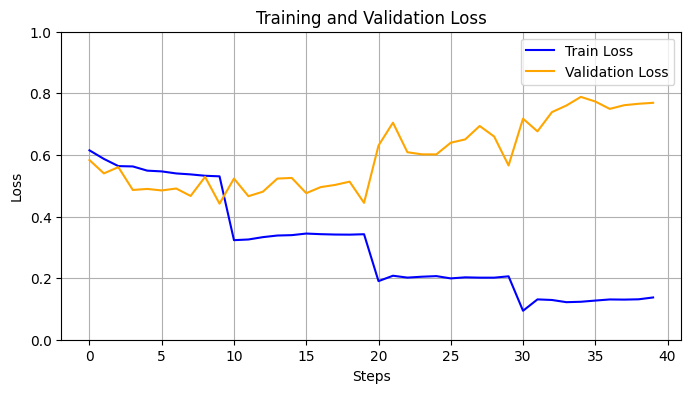

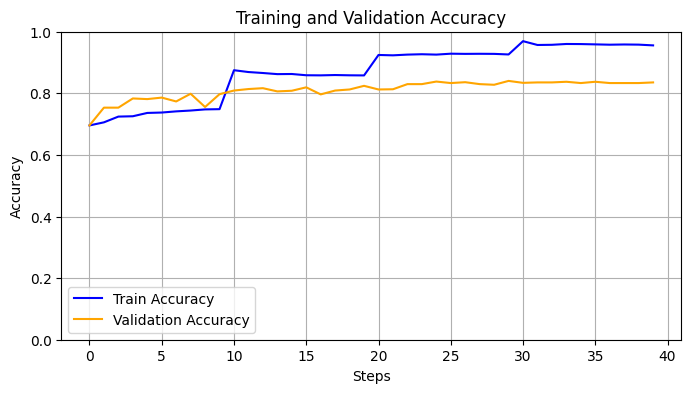

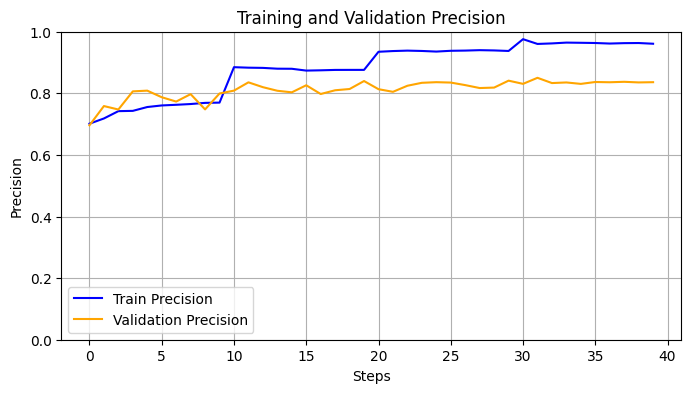

In [53]:
import matplotlib.pyplot as plt

def plot_training_stats(step_stats, stat_name, ylabel):
    train_steps, train_values, valid_steps, valid_values = step_stats
    plt.figure(figsize=(8, 4))
    plt.plot(train_steps, train_values, label=f"Train {stat_name}", color="blue")
    plt.plot(valid_steps, valid_values, label=f"Validation {stat_name}", color="orange")
    plt.xlabel("Steps")
    plt.ylabel(ylabel)
    plt.ylim([0,1])
    plt.title(f"Training and Validation {stat_name}")
    plt.legend()
    plt.grid()
    plt.show()

# step-wise stats for plotting
train_steps = list(range(len(train_losses)))
valid_steps = [i for i in range(len(valid_losses))]

plot_training_stats(
    (train_steps, train_losses, valid_steps, valid_losses),
    stat_name="Loss",
    ylabel="Loss"
)

plot_training_stats(
    (train_steps, train_accuracies, valid_steps, valid_accuracies),
    stat_name="Accuracy",
    ylabel="Accuracy"
)

plot_training_stats(
    (train_steps, train_precisions, valid_steps, valid_precisions),
    stat_name="Precision",
    ylabel="Precision"
)

The training and validation metrics obtained during the training, reveal the following insights:

1. **Loss**: The training loss consistently decreases, indicating that the model is learning during training. However, the validation loss shows more fluctuation and an upward trend after a certain point, suggesting potential overfitting.

2. **Accuracy**: Training accuracy improves steadily, nearing 1.0. Validation accuracy plateaus after an initial increase, indicating limited generalization improvement over time.

3. **Precision**: Training precision improves similarly to accuracy. Validation precision stabilizes early but remains lower than training precision, highlighting potential overfitting or class imbalance.

Overall, the model performs well on the training set but struggles to generalize effectively, as shown by the gap between training and validation metrics.

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

total_test_loss, total_test_acc, total_test_precision = 0, 0, 0
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        batch_tokens, batch_masks, batch_labels = [tensor.to(device) for tensor in batch]
        outputs = model(batch_tokens, attention_mask=batch_masks, labels=batch_labels.long())
        loss, logits = outputs.loss, outputs.logits

        total_test_loss += loss.item()
        logits = logits.cpu().numpy()
        labels = batch_labels.cpu().numpy()

        # Append true and predicted labels for confusion matrix
        true_labels.extend(labels)
        predicted_labels.extend(np.argmax(logits, axis=1))

        # sum batch stats
        total_test_acc += accuracy(logits, labels)
        total_test_precision += precision(logits, labels)

# calculate avgs
test_loss = total_test_loss / len(test_dataloader)
test_acc = total_test_acc / len(test_dataloader)
test_precision = total_test_precision / len(test_dataloader)

Test Results:
  Loss: 0.926
  Accuracy: 0.792
  Precision: 0.830


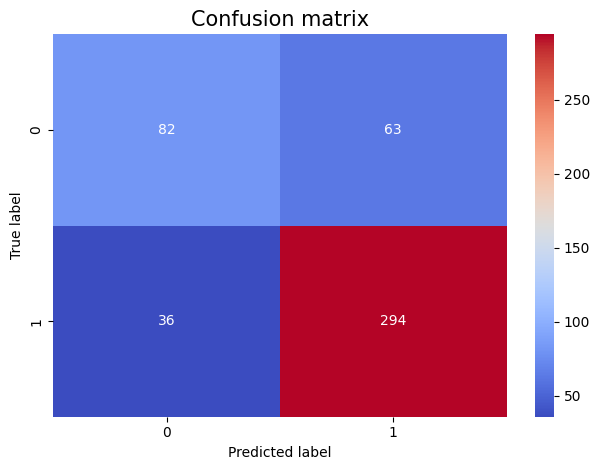

In [36]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix', fontsize=15)
plt.tight_layout()

print("Test Results:")
print(f"  Loss: {test_loss:.3f}")
print(f"  Accuracy: {test_acc:.3f}")
print(f"  Precision: {test_precision:.3f}")

The model correctly identifies 294 positive samples (True Positives) and 82 negative samples (True Negatives). However, it misclassifies 63 negatives as positives (False Positives) and 36 positives as negatives (False Negatives).

The higher count of False Positives suggests the model **over-predicts the positive class**, possibly due to **dataset imbalance**, a **small dataset** or learned biases. Addressing this could involve adjusting the classification threshold, balancing the dataset, or applying regularization.

While the model performs well overall, reducing False Negatives is crucial in scenarios where missing positive cases is costly. Optimization techniques like fine-tuning, better preprocessing, or targeted augmentation could further enhance performance.

### With lower threshold

In [56]:
total_test_loss, total_test_acc, total_test_precision = 0, 0, 0
true_labels = []
predicted_labels = []

model.eval()
new_threshold = 0.99  # Lower threshold

with torch.no_grad():
    for batch in test_dataloader:
        batch_tokens, batch_masks, batch_labels = [tensor.to(device) for tensor in batch]
        outputs = model(batch_tokens, attention_mask=batch_masks, labels=batch_labels.long())
        loss, logits = outputs.loss, outputs.logits

        total_test_loss += loss.item()
        logits = logits.cpu().numpy()
        labels = batch_labels.cpu().numpy()

        # apply the new threshold
        # convert logits to probabilities using softmax
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
        predictions = (probs[:, 1] > new_threshold).astype(int)

        # append true and predicted labels for confusion matrix
        true_labels.extend(labels)
        predicted_labels.extend(predictions)

        # sum batch stats
        total_test_acc += accuracy(logits, labels)
        total_test_precision += precision(logits, labels)

# calculate avgs
test_loss = total_test_loss / len(test_dataloader)
test_acc = total_test_acc / len(test_dataloader)
test_precision = total_test_precision / len(test_dataloader)

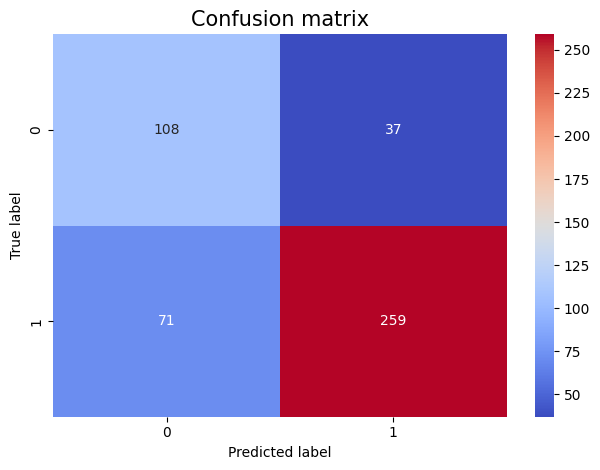

In [58]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix', fontsize=15)
plt.tight_layout()

The updated confusion matrix reflects the impact of adjusting the classification threshold. The model now identifies more negative samples correctly, with 108 True Negatives (up from 82), but this comes at the cost of slightly fewer True Positives, now 259 (down from 294).

This trade-off indicates a shift in the model's decision boundary, reducing False Positives while increasing False Negatives. This adjustment prioritizes correctly identifying negative samples but slightly decreases the detection of positive ones.

Such changes may be beneficial depending on the specific goals of the task. If reducing False Positives is more critical, this threshold adjustment is an improvement; however, if minimizing False Negatives is crucial, further optimization might be necessary.

### Sample sentences to test

In [76]:
# sample sentences in Spanish (some correct, some grammatically incorrect)
test_sentences = [
    ("Él están contento.", 0),  # Incorrect
    ("Soy feliz porque tengo una familia maravillosa y espléndida.", 1),  # Correct
    ("Todo lo días está soleado.", 0),  # Incorrect
    ("¿Qué has hecho hoy?", 1),  # Correct
    ("Nosotros tengo hambre.", 0),  # Inorrect
    ("Tu tener un carro rojo.", 0),  # Incorrect
    ("Los niño juegan en la parque.", 0),  # Incorrect
    ("Es bueno estudiar para aprender más.", 1),  # Correct
    ("Juan y Pedro estudia para el examen.", 0),  # Incorrect
    ("¿Por qué no vienes a la fiesta mañana?", 1)  # Correct
]


test_sentences_with_tokens = ["[CLS] " + sentence[0] + " [SEP]" for sentence in test_sentences]
test_tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in test_sentences_with_tokens]
test_token_ids = tokenizer(test_sentences_with_tokens, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
test_attention_masks = test_token_ids["attention_mask"]

test_input_ids = test_token_ids["input_ids"].to(device)
test_attention_masks = test_attention_masks.to(device)

model.eval()
with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_masks)
    logits = outputs.logits

probs = torch.softmax(logits.clone().detach().cpu(), dim=1).numpy()
predictions = (probs[:, 1] > new_threshold).astype(int)

# display the sentences along with the model's predictions
for i, sentence in enumerate(test_sentences):
    print(f"Sentence: {sentence}")
    print(f"    Actual: {test_sentences[i][1]}, Predicted: {predictions[i]}, with a probability of {probs[i, predictions[i]]:.4f}")

Sentence: ('Él están contento.', 0)
    Actual: 0, Predicted: 0, with a probability of 0.9959
Sentence: ('Soy feliz porque tengo una familia maravillosa y espléndida.', 1)
    Actual: 1, Predicted: 1, with a probability of 0.9988
Sentence: ('Todo lo días está soleado.', 0)
    Actual: 0, Predicted: 1, with a probability of 0.9945
Sentence: ('¿Qué has hecho hoy?', 1)
    Actual: 1, Predicted: 1, with a probability of 0.9989
Sentence: ('Nosotros tengo hambre.', 0)
    Actual: 0, Predicted: 0, with a probability of 0.9949
Sentence: ('Tu tener un carro rojo.', 0)
    Actual: 0, Predicted: 0, with a probability of 0.9983
Sentence: ('Los niño juegan en la parque.', 0)
    Actual: 0, Predicted: 0, with a probability of 0.9974
Sentence: ('Es bueno estudiar para aprender más.', 1)
    Actual: 1, Predicted: 1, with a probability of 0.9981
Sentence: ('Juan y Pedro estudia para el examen.', 0)
    Actual: 0, Predicted: 0, with a probability of 0.9961
Sentence: ('¿Por qué no vienes a la fiesta maña